##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

## Read the CSV datafiles (Train and Test)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
train_data = pd.read_csv("Train.csv", sep=',')
train_data.drop(columns = 'Unnamed: 0', inplace = True)
test_data = pd.read_csv("Test.csv", sep=',')

# separating instance and label for Train and Test
X_train_raw = train_data['text']
Y_train = train_data['sentiment']
X_test_raw = test_data['text']

#check the result
print("Train length:",len(X_train_raw))
print("Test length:",len(X_test_raw))

Train length: 21802
Test length: 6099


Number of tweets of each class
neutral     12659
positive     5428
negative     3715
Name: sentiment, dtype: int64


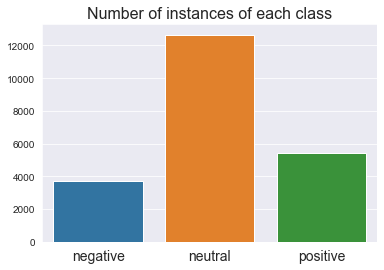

In [3]:
# inspect the distribution of class labels
count = Y_train.value_counts()
print("Number of tweets of each class")
print(count)

sns.barplot(x=['negative', 'neutral', 'positive'], y=[count['negative'], count['neutral'], count['positive']])
plt.xticks(fontsize=14)
plt.title('Number of instances of each class', fontsize=16)
plt.savefig("distribution.png")
plt.show()

## Data Preprocessing

- expand contractions
- remove links
- remove non-ASCII characters, punctuations, spacing characters from the text
- remove words that are only a single character long or contain digits
- tokenize words and remove stopwords
- Snowball Stemmer

In [4]:
# pip install unidecode
# pip install contractions

In [5]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
import unidecode
import contractions 

In [6]:
def contain_digit(word):
    '''
    Check and return true if a word contains digits.
    '''
    for char in word:
        if char.isdigit():
            return True
    return False


def preprocess(text):
    '''
    Preprocess the raw text data into tokenized lists of words.
    Input: a single tweet
    Output: a list of filtered terms
    '''
    # expand contractions (e.g. can't -> cannot)
    revised_text = contractions.fix(text)
    
    # remove links from the text
    revised_text = re.sub(r'\w+:\/{2}[\w-]+(\.[\w\/-]+)*', '', revised_text)
    
    # remove non-ASCII characters
    revised_text = re.sub(r'[^\x00-\x7F]', r' ', revised_text)

    # remove any spacing characters
    revised_text = re.sub(r'[\n\t\s]+', r' ', revised_text)
    
    # tokenize the text into words
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tokens = tokenizer.tokenize(revised_text)
    
    # remove stopwords, but keep 'not' and 'no' in text as they indicate negation
    keep = ['no', 'not']
    stop_words = set(stopwords.words('english'))
    revised_lst = [w for w in tokens if w in keep or w not in stop_words]
    
    # remove punctuations in text
    revised_lst = [w for w in revised_lst if w not in string.punctuation]
    
    # remove words that contain numbers
    revised_lst = [w for w in revised_lst if not contain_digit(w)]
    
    # remove words that are only a single character long
    # reduce words back into their stem form except hashtags
    stemmer = SnowballStemmer("english")
    revised_lst = [w if w[0] == '#' else stemmer.stem(w) for w in revised_lst if len(w) != 1]

    return revised_lst

## Feature Engineering

### N-gram TF-IDF Vectorization

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [8]:
def n_gram_tfidf(X_train_raw, X_test_raw, n = 1):
    '''
    Apply n-gram algorithms while doing TF-IDF vectorization.
    n: {1: 'unigram', 2: 'bigram', n: '1-n gram'}, default = 1
    '''
    if n==1:
        # unigram
        tfidf_vectorizer = TfidfVectorizer(analyzer=preprocess)
        X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_raw)
        X_test_tfidf = tfidf_vectorizer.transform(X_test_raw)
        
    else:
        # join the tokenized words into sentences
        train_x_cleaned = []
        test_cleaned = []
        
        for i in X_train_raw:
            train_x_cleaned.append(' '.join(preprocess(i)))
        for i in X_test_raw:
            test_cleaned.append(' '.join(preprocess(i)))
    
        if n==2:
            # bigram
            vectorizer = TfidfVectorizer(ngram_range=(2,2))
            X_train_tfidf = vectorizer.fit_transform(train_x_cleaned)
            X_test_tfidf = vectorizer.transform(test_cleaned)
        
        else:
            # 1-n gram
            vectorizer = TfidfVectorizer(ngram_range=(1,n))
            X_train_tfidf = vectorizer.fit_transform(train_x_cleaned)
            X_test_tfidf = vectorizer.transform(test_cleaned)
            
    return X_train_tfidf, X_test_tfidf

### sampling

In [9]:
# pip install imblearn

In [10]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [11]:
def sampling(X_train_tfidf, Y_train, sampling_method = None):
    '''
    Apply sampling method to the cleaned training data.
    sampling_method: {'under', 'over', None}, default = None
        - 'under': random under sampling
        - 'over': random over sampling
        - None: no sampling method applied 
    '''
    if sampling_method == 'under':
        rus = RandomUnderSampler(random_state=42) 
        return rus.fit_resample(X_train_tfidf, Y_train)
    elif sampling_method == 'over':
        ros = RandomOverSampler(random_state=42)
        return ros.fit_resample(X_train_tfidf, Y_train)
    else:
        return X_train_tfidf, Y_train

### Feature Selection

In [12]:
from sklearn.feature_selection import SelectKBest, chi2

In [13]:
def kBest_chi2(i: int, X_train_smp, Y_train, X_test_tfidf):
    '''
    Select the first i best features using Chi-square test. 
    '''
    x2 = SelectKBest(chi2, k=i)
    X_train_kBest = x2.fit_transform(X_train_smp,Y_train)
    X_test_kBest = x2.transform(X_test_tfidf)
    return X_train_kBest, X_test_kBest

## Train, Test and Evaluation

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

def apply_model(clf, X_train, y_train, X_val, y_val):
    '''
    Fit a classifier to the training data and use the model to predict the test data.
    '''
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_val)
    evaluate(y_val, prediction)
    return 

def evaluate(y_test, prediction):
    '''
    Generate evaluation metrics.
    '''
    print(classification_report(y_test, prediction))
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, prediction)
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
    plt.xlabel('Prediction', fontsize=14)
    plt.ylabel('Actual label', fontsize=14)
    plt.title('Confusion matrix', fontsize=16)
    plt.xticks(np.arange(3), labels = ['negative', 'neutral', 'positive'], fontsize=12)
    plt.yticks(np.arange(3), labels = ['negative', 'neutral', 'positive'], fontsize=12, rotation=0)
    plt.savefig("cm.png", bbox_inches="tight")
    plt.show()

## Machine Learning Models

In [15]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
import time

In [16]:
# train-test split & apply tfidf vectorization
X_train, X_val, y_train, y_val = train_test_split(X_train_raw, Y_train, test_size=0.3, random_state=42)
X_train_tfidf, X_val_tfidf = n_gram_tfidf(X_train, X_val, n=1)  # adjust n-gram approach here
feature_size = X_train_tfidf.shape[1]
print("Train feature space size (using TFIDF):",X_train_tfidf.shape)
print("Test feature space size (using TFIDF):",X_val_tfidf.shape)
print("\n")

# sampling 
X_train_smp, Y_train_smp = sampling(X_train_tfidf, y_train, sampling_method = 'under') # adjust sampling methods here

# sub-sample the validation set to obtain a balanced dataset
X_val_tfidf, y_val = sampling(X_val_tfidf, y_val, sampling_method = 'under')
print("New train class distribution after sampling:", Counter(Y_train_smp))
print("New test class distribution after sampling:", Counter(y_val))
print("\n")

# choose k best (top 10%) features using chi2 test
X_train_kBest, X_val_kBest = kBest_chi2(int(0.1*feature_size), X_train_smp, Y_train_smp, X_val_tfidf)
print("Train feature space size (after feature selection):", X_train_kBest.shape)
print("\n")

Train feature space size (using TFIDF): (15261, 18142)
Test feature space size (using TFIDF): (6541, 18142)


New train class distribution after sampling: Counter({'negative': 2578, 'neutral': 2578, 'positive': 2578})
New test class distribution after sampling: Counter({'negative': 1137, 'neutral': 1137, 'positive': 1137})


Train feature space size (after feature selection): (7734, 1814)




### Zero-R (baseline)

              precision    recall  f1-score   support

    negative       0.33      1.00      0.50      1137
     neutral       0.00      0.00      0.00      1137
    positive       0.00      0.00      0.00      1137

    accuracy                           0.33      3411
   macro avg       0.11      0.33      0.17      3411
weighted avg       0.11      0.33      0.17      3411



c:\Users\61432\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\61432\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\61432\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


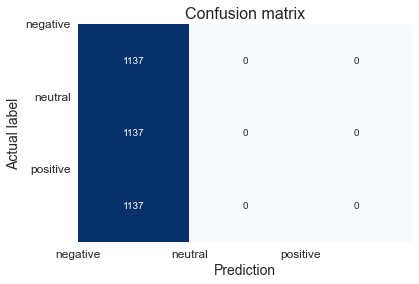

Time to run the model is: 0.16532588005065918


In [17]:
# record the how long does the model take to train and test the data
t0 = time.time()

zero_r = DummyClassifier(strategy="most_frequent")
apply_model(zero_r, X_train_kBest, Y_train_smp, X_val_kBest, y_val)

t1 = time.time() - t0
print("Time to run the model is:", t1)

### Bernoulli Naive Bayes

              precision    recall  f1-score   support

    negative       0.66      0.69      0.68      1137
     neutral       0.51      0.42      0.46      1137
    positive       0.62      0.70      0.66      1137

    accuracy                           0.61      3411
   macro avg       0.60      0.61      0.60      3411
weighted avg       0.60      0.61      0.60      3411



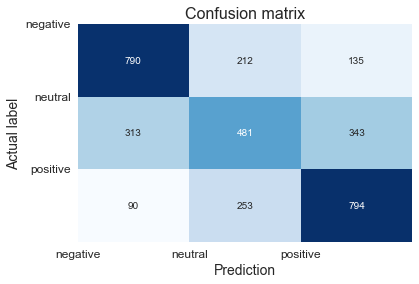

Time to run the model is: 0.20330500602722168


In [18]:
t0 = time.time()
bnb = BernoulliNB()
apply_model(bnb, X_train_kBest, Y_train_smp, X_val_kBest, y_val)
t1 = time.time() - t0
print("Time to run the model is:", t1)

### K Nearest Neighbours

              precision    recall  f1-score   support

    negative       0.59      0.50      0.54      1137
     neutral       0.40      0.57      0.47      1137
    positive       0.60      0.43      0.50      1137

    accuracy                           0.50      3411
   macro avg       0.53      0.50      0.50      3411
weighted avg       0.53      0.50      0.50      3411



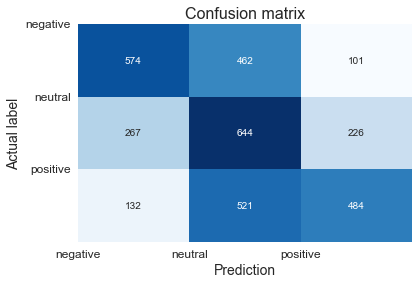

Time to run the model is: 0.8213129043579102


In [19]:
t0 = time.time()
knn5 = KNeighborsClassifier(n_neighbors=5)
apply_model(knn5, X_train_kBest, Y_train_smp, X_val_kBest, y_val)
t1 = time.time() - t0
print("Time to run the model is:", t1)

### Logistic Regression

              precision    recall  f1-score   support

    negative       0.67      0.69      0.68      1137
     neutral       0.50      0.49      0.49      1137
    positive       0.66      0.67      0.67      1137

    accuracy                           0.61      3411
   macro avg       0.61      0.61      0.61      3411
weighted avg       0.61      0.61      0.61      3411



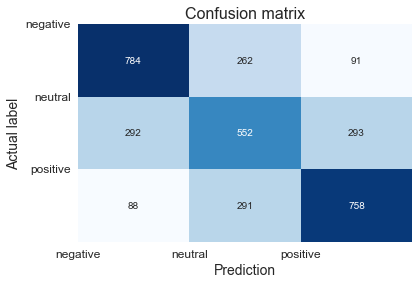

Time to run the model is: 0.26116156578063965


In [20]:
t0 = time.time()
lg_clf = LogisticRegression(solver='saga', multi_class='multinomial', C=6, 
                            class_weight='balanced', max_iter=100000, penalty = 'l2')
apply_model(lg_clf, X_train_kBest, Y_train_smp, X_val_kBest, y_val)
t1 = time.time() - t0
print("Time to run the model is:", t1)

### Support Vector Machine 

              precision    recall  f1-score   support

    negative       0.65      0.68      0.66      1137
     neutral       0.50      0.47      0.48      1137
    positive       0.65      0.65      0.65      1137

    accuracy                           0.60      3411
   macro avg       0.60      0.60      0.60      3411
weighted avg       0.60      0.60      0.60      3411



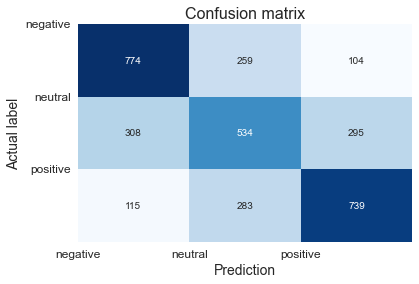

Time to run the model is: 4.872695446014404


In [21]:
t0 = time.time()
svm = SVC(kernel='rbf', C=5, decision_function_shape='ovo')
apply_model(svm, X_train_kBest, Y_train_smp, X_val_kBest, y_val)
t1 = time.time() - t0
print("Time to run the model is:", t1)

### Stacking

              precision    recall  f1-score   support

    negative       0.68      0.70      0.69      1137
     neutral       0.51      0.49      0.50      1137
    positive       0.67      0.68      0.67      1137

    accuracy                           0.62      3411
   macro avg       0.62      0.62      0.62      3411
weighted avg       0.62      0.62      0.62      3411



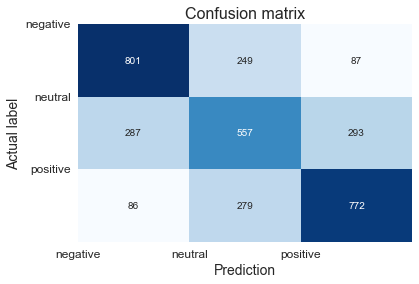

Time to run the model is: 18.73852276802063


In [22]:
t0 = time.time()
estimators = {
    ('lg', LogisticRegression(solver='saga', multi_class='multinomial', C=6, max_iter=1000, penalty = 'l2')),
    ('svm', SVC(kernel='rbf', C=5)),
    ('bnb', BernoulliNB()),
}

stk_clf = StackingClassifier(estimators, final_estimator=LogisticRegression(solver='saga', 
                            multi_class='multinomial', C=6, max_iter=10000, penalty = 'l2'))

apply_model(stk_clf, X_train_kBest, Y_train_smp, X_val_kBest, y_val)
t1 = time.time() - t0
print("Time to run the model is:", t1)

## Evaluation
- Chooing k for k Best feature selection
- N-gram & sampling methods comparison
- Learning curve

In [23]:
def plot_line(df, filename, title, xlabel, ylabel):
    '''
    Produce a line plot for a given dataframe.
    Print and save the graph to the given filename.
    '''
    sns.lineplot(data = df, dashes = False)
    plt.title(title, size = 16)
    plt.xlabel(xlabel= xlabel, fontsize = 14)
    plt.ylabel(ylabel = ylabel, fontsize = 14)
    plt.legend(fontsize = 10)
    plt.savefig(filename)
    plt.show()


def accuracy_k(n_gram, sampling_method, X_train_raw, Y_train):
    '''
    Iterate over multiple k values and plot accuracy of each model with respect to k.
    '''
    X_train, X_val, y_train, y_val = train_test_split(X_train_raw, Y_train, test_size=0.3, random_state=42)
    X_train_tfidf, X_val_tfidf = n_gram_tfidf(X_train, X_val, n_gram)
    feature_size = X_train_tfidf.shape[1]
    X_train_smp, Y_train_smp = sampling(X_train_tfidf, y_train, sampling_method)
    
    # sub-sample the validation set to obtain a balanced dataset
    X_val_tfidf, y_val = sampling(X_val_tfidf, y_val, sampling_method = 'under')
    
    clf_list = [bnb, knn5, lg_clf, svm, stk_clf]
    acc_list = []
    k_val = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 1]
    
    for clf in clf_list:
        acc = []
        for k in k_val:
            X_train_kBest, X_val_kBest = kBest_chi2(int(k*feature_size), X_train_smp, Y_train_smp, X_val_tfidf)
            
            clf.fit(X_train_kBest, Y_train_smp)
            acc.append(clf.score(X_val_kBest, y_val))
        
        # print(k_val)
        # print(acc)
        acc_list.append(acc)
        
    data = {'Top % features': [100*i for i in k_val], 'BNB': acc_list[0],
            'KNN5': acc_list[1], 'LG': acc_list[2], 'SVM': acc_list[3], 'STK': acc_list[4]}
    df = pd.DataFrame(data)
    df = df.set_index('Top % features')
    
    # plot the accuracy of each model versus different values of k
    plot_line(df, filename="kVsAcc.png", title="K value vs Accuracy", xlabel='Top % features', ylabel='Accuracy')
    

In [24]:
from sklearn.metrics import f1_score, accuracy_score

def preprocess_cmp(scoring = 'accuracy'):
    '''
    For each model, generate the accuracy/ macro-avg f1 score for every combination 
    of preprocessing techniques (n-gram & sampling).
    Parameter:
        scoring: {'accuracy', 'f1'}, default = 'accuracy'
    '''
    n_gram_choice = [1, 2, 3]
    sample = [None, 'under', 'over']
    df_dict = dict()

    for clf in list(clf_dict.keys())[1:]:
        acc_list = []
        f1_list = []
        for n in n_gram_choice:
            acc = []
            f1 = []
            for sm in sample:
                X_train, X_val, y_train, y_val = train_test_split(X_train_raw, Y_train, test_size=0.3, random_state=42)
                X_train_tfidf, X_val_tfidf = n_gram_tfidf(X_train, X_val, n)
                feature_size = X_train_tfidf.shape[1]
                X_train_smp, Y_train_smp = sampling(X_train_tfidf, y_train, sm)
                
                # sub-sample the validation set to obtain a balanced dataset
                X_val_tfidf, y_val = sampling(X_val_tfidf, y_val, sampling_method = 'under')
                
                X_train_kBest, X_val_kBest = kBest_chi2(int(0.1*feature_size), X_train_smp, Y_train_smp, X_val_tfidf)

                clf.fit(X_train_kBest, Y_train_smp)
                prediction = clf.predict(X_val_kBest)
                
                acc.append(accuracy_score(y_val, prediction))
                f1.append(f1_score(y_val, prediction, average='macro'))
                
            acc_list.append(acc)
            f1_list.append(f1)

        data = {'sampling': sample, 'unigram': acc_list[0], 'bigram': acc_list[1], '1-3 gram': acc_list[2]}
        df = pd.DataFrame(data)
        df = df.set_index('sampling')
        df_dict[clf_dict[clf]] = df
    
    for i in df_dict.keys():
        print(i)
        print("-------------------------------------------")
        print(df_dict[i])
        print("\n")

In [25]:
def train_test_acc(n_gram, sampling_method, clf, X_train_raw, Y_train):
    '''
    Create a dataframe containing different propotion of test set 
    as well as accuracy of train and test data.
    '''
    test_percentage = list(range(9, 0, -1))
    train_acc = []
    test_acc = []
    for i in test_percentage:
        X_train, X_val, y_train, y_val = train_test_split(X_train_raw, Y_train, test_size=i*0.1, random_state=42)
        X_train_tfidf, X_val_tfidf = n_gram_tfidf(X_train, X_val, n_gram)
        feature_size = X_train_tfidf.shape[1]

        X_train_smp, Y_train_smp = sampling(X_train_tfidf, y_train, sampling_method)
        
        # sub-sample the validation set to obtain a balanced dataset
        X_val_tfidf, y_val = sampling(X_val_tfidf, y_val, sampling_method = 'under')
        X_train_kBest, X_val_kBest = kBest_chi2(int(0.1*feature_size), X_train_smp, Y_train_smp, X_val_tfidf)
        
        clf.fit(X_train_kBest, Y_train_smp)
        train_acc.append(clf.score(X_train_kBest, Y_train_smp))
        test_acc.append(clf.score(X_val_kBest, y_val))
    
    data = {'percentage': [100-10*i for i in test_percentage], 'train accuracy': train_acc, 'test accuracy': test_acc}
    df = pd.DataFrame(data)
    df = df.set_index('percentage')
    return df

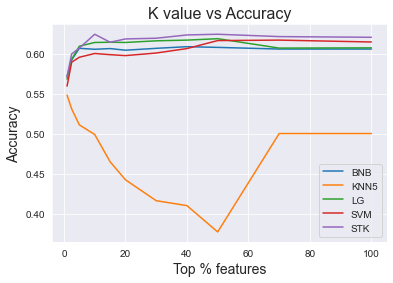

Bernolli Naive Bayes
-------------------------------------------
           unigram    bigram  1-3 gram
sampling                              
None      0.557901  0.376429  0.397244
under     0.605394  0.497801  0.603342
over      0.605394  0.411023  0.446497


K Nearest Neighbour
-------------------------------------------
           unigram    bigram  1-3 gram
sampling                              
None      0.406039  0.389622  0.391674
under     0.498974  0.453826  0.501319
over      0.472882  0.421870  0.445910


Logistic Regression
-------------------------------------------
           unigram    bigram  1-3 gram
sampling                              
None      0.618001  0.489592  0.628555
under     0.613896  0.502199  0.616242
over      0.605394  0.487540  0.621812


SVM
-------------------------------------------
           unigram    bigram  1-3 gram
sampling                              
None      0.553797  0.418059  0.560833
under     0.600117  0.467312  0.596306
over      0.

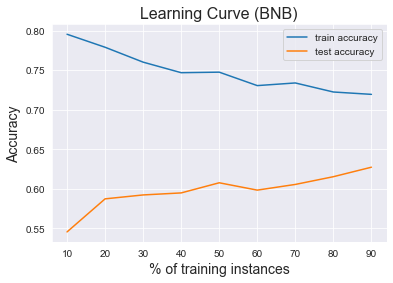

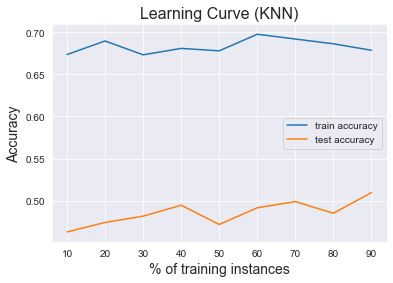

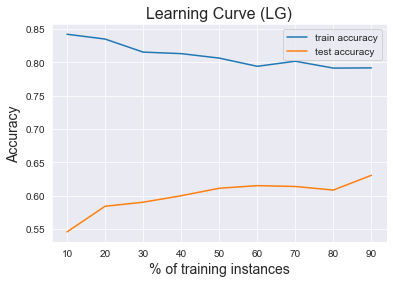

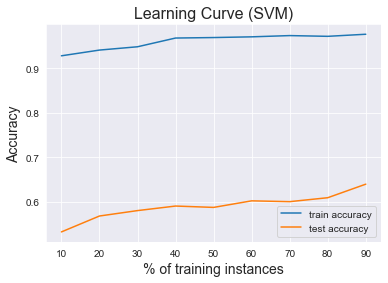

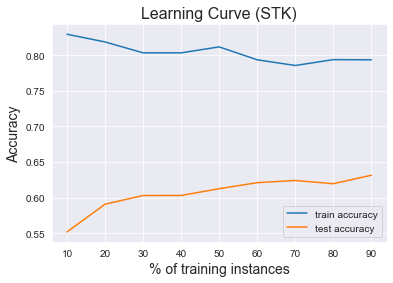

In [27]:
# Uncomment the line below to see the accuracy of each model versus different k values
# You can adjust the parameters 'n_gram': {1,2,3} and 'sampling_method': {None, 'under', 'over'}

accuracy_k(1, 'under', X_train_raw, Y_train)


# Uncomment lines below to see accuracy/f1 comparison for different combination of n-gram and sampling methods
# Change the parameter 'accuracy' to 'f1' to see f1 score comparison

clf_dict = {zero_r:"Zero-R", bnb: "Bernolli Naive Bayes", knn5: "K Nearest Neighbour", 
            lg_clf: "Logistic Regression", svm: "SVM", stk_clf: "Stacking"}
preprocess_cmp(scoring = 'accuracy')


# Uncomment lines below to see the learning curve for five models

clf_dict = {bnb: "BNB", knn5: "KNN", lg_clf: "LG", svm: "SVM", stk_clf: "STK"}
for clf in clf_dict:
    df = train_test_acc(1, 'under', clf, X_train_raw, Y_train)
    plot_line(df, f'lc_{clf_dict[clf].lower()}.png', f'Learning Curve ({clf_dict[clf]})', "% of training instances", "Accuracy")
    print("\n")